In [6]:
import pandas as pd
import datetime
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [7]:
file_path = '/content/cad_jpy.csv'
yen = pd.read_csv(file_path,index_col='Date',infer_datetime_format=True,parse_dates=True)
yen.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [8]:
# Trim the dataset to begin on January 1st, 1990

yen_90 = yen.loc['1990-01-01':,:]
yen_90.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


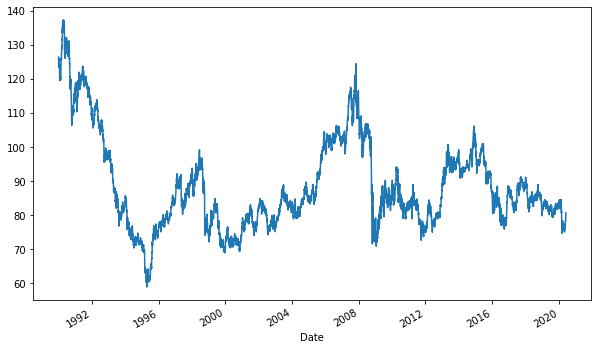

In [9]:
# Plot just the "Price" column from the dataframe
yen_90.Price.plot(figsize=(10,6
                           ))

In [10]:
#Question: Do you see any patterns, long-term and/or short?
print("Answer: It is possible to see the average value of cad_jpy currency pair around 85, with the pattern being that the JPY getting stronger compared to CAD")

Answer: It is possible to see the average value of cad_jpy currency pair around 85, with the pattern being that the JPY getting stronger compared to CAD


In [11]:
import statsmodels.api as sm

In [12]:
# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series

yen_noise,yen_trends = sm.tsa.filters.hpfilter(yen_90['Price'])

In [14]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above

yen_hp = pd.DataFrame()

yen_hp['Price'] = yen_90['Price']
yen_hp['noise'] = yen_noise
yen_hp['trends'] = yen_trends


yen_hp.head()

,Price,noise,trends
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


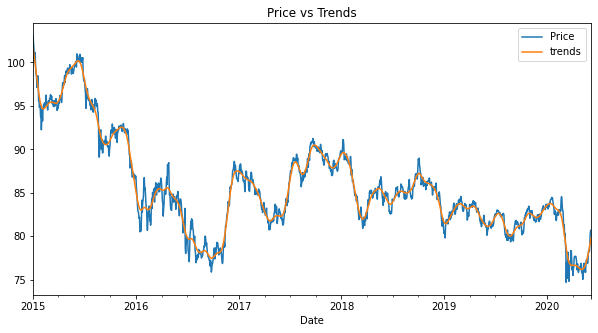

In [15]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present

yen_pvst = yen_hp.loc["2015-01-01":,:]

yen_pvst = yen_pvst.drop(columns='noise')

yen_pvst.plot(figsize=(10,5),title='Price vs Trends').get_figure().savefig('Price vs Trends.png')

In [16]:
#Question: Do you see any patterns, long-term and/or short? 
print("Answer: The pattern is that the JPY is getting stronger compared to CAD")

Answer: The pattern is that the JPY is getting stronger compared to CAD


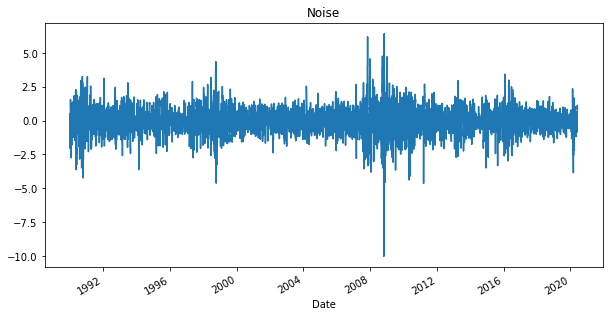

In [18]:
# Plot the Settle Noise
yen_noise.plot(figsize=(10,5), title='Noise').get_figure().savefig('noise.png')

In [19]:
# Forecasting Returns using an ARMA Model
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
import numpy as np
returns = (yen_90[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [20]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
from statsmodels.tsa.arima_model import ARMA
model_arma = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results_arma = model_arma.fit()

In [21]:
# Output model summary results:
results_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Mon, 09 Aug 2021   AIC                          19513.955
Time:                        01:02:53   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.201      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.031      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1698           +0.0000j           42.1698            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

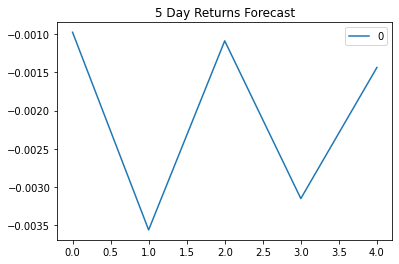

In [22]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results_arma.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast").get_figure().savefig('arma.png')

In [23]:
# Question: Based on the p-value, is the model a good fit?
print("Answer: Based on the p-value, this model is not a good fit because the p value is more than 0.05. To be considered a good fit, p < 0.05.")

Answer: Based on the p-value, this model is not a good fit because the p value is more than 0.05. To be considered a good fit, p < 0.05.


In [25]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))

from statsmodels.tsa.arima_model import ARIMA
model_arima = ARIMA(yen_90['Price'], order=(5, 1, 1))

# Fit the model
results_arima = model_arima.fit()

In [26]:
# Output model summary results:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Mon, 09 Aug 2021   AIC                          17507.244
Time:                        01:08:43   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.856      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1892           +0.0000j            2.1892            0.0000
-----------------------------------------------------------------------------
"""

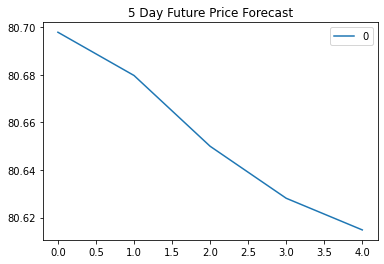

In [27]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results_arima.forecast(steps=5)[0]).plot(title="5 Day Future Price Forecast").get_figure().savefig('arima.png')


In [28]:
# Question: What does the model forecast will happen to the Japanese Yen in the near term?
print("Answer: The model forecast shows that the Japonese Yen will get stronger compared to CAD, it means that the Yen will increase in value")

Answer: The model forecast shows that the Japonese Yen will get stronger compared to CAD, it means that the Yen will increase in value


In [31]:

from arch import arch_model

# Estimate a GARCH model:
model_garch = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
results_garch = model_garch.fit(disp="on")

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8943.240855480453
Iteration:      2,   Func. Count:     17,   Neg. LLF: 8937.945261935267
Iteration:      3,   Func. Count:     24,   Neg. LLF: 8932.682519606544
Iteration:      4,   Func. Count:     30,   Neg. LLF: 8928.838875712318
Iteration:      5,   Func. Count:     37,   Neg. LLF: 8922.473485907225
Iteration:      6,   Func. Count:     46,   Neg. LLF: 8914.625799177515
Iteration:      7,   Func. Count:     53,   Neg. LLF: 8913.39036129286
Iteration:      8,   Func. Count:     59,   Neg. LLF: 8911.112109801084
Iteration:      9,   Func. Count:     65,   Neg. LLF: 8911.027320871446
Iteration:     10,   Func. Count:     71,   Neg. LLF: 8911.022077735988
Iteration:     11,   Func. Count:     77,   Neg. LLF: 8911.021067647998
Iteration:     12,   Func. Count:     83,   Neg. LLF: 8911.020797479123
Iteration:     13,   Func. Count:     89,   Neg. LLF: 8911.020764882265


In [32]:
# Summarize the model results
results_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Mon, Aug 09 2021   Df Residuals:                     7928
Time:                        01:10:39   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

In [33]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [34]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = results_garch.forecast(start=last_day, horizon=forecast_horizon)

In [35]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()


,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566029,12.573718,12.581301,12.588778,12.596153


In [36]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566029
h.2,12.573718
h.3,12.581301
h.4,12.588778
h.5,12.596153


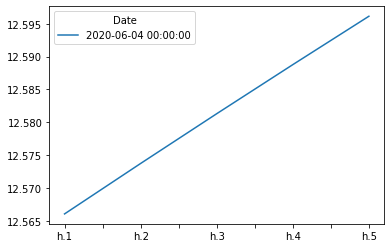

In [37]:
# Plot the final forecast
final.plot().get_figure().savefig('garch.png')

In [38]:
# Question: What does the model forecast will happen to volatility in the near term?
print("Answer: The model forecast shows that the volatility will increase in the near term")

Answer: The model forecast shows that the volatility will increase in the near term


In [39]:
# Conclusions
print("CONCLUSIONS")
print("----------------------------")
#Based on your time series analysis, would you buy the yen now?
print("Based on your time series analysis, would you buy the yen now?")
print("Based on this analysis, the YEN will get stronger, so it's a good investment oportunity")
print("----------------------------")
 
#Is the risk of the yen expected to increase or decrease?
print("Is the risk of the yen expected to increase or decrease?")
print("It is expected that the risk (volatility) will increase, so others factors should be addressed before investment")
print("----------------------------")
 
#Based on the model evaluation, would you feel confident in using these models for trading?
print("Based on the model evaluation, would you feel confident in using these models for trading?")
print("Based on this model, I'm not confident to use it because the model is not a good fit due the p > 0.05. Which should be p < 0.05 to be a good fit")
print("Also, before trading the CAD/JPY always take into account Canada's and Japan's respective economic policies and unemployment rates, exports and imports statics and GDP growth")

CONCLUSIONS
----------------------------
Based on your time series analysis, would you buy the yen now?
Based on this analysis, the YEN will get stronger, so it's a good investment oportunity
----------------------------
Is the risk of the yen expected to increase or decrease?
It is expected that the risk (volatility) will increase, so others factors should be addressed before investment
----------------------------
Based on the model evaluation, would you feel confident in using these models for trading?
Based on this model, I'm not confident to use it because the model is not a good fit due the p > 0.05. Which should be p < 0.05 to be a good fit
Also, before trading the CAD/JPY always take into account Canada's and Japan's respective economic policies and unemployment rates, exports and imports statics and GDP growth


In [ ]:
results = Path("Your_path_here")
with open(results,'w') as file:
    file.write("CONCLUSIONS\n")
    file.write("----------------------------\n")
    
    file.write("Based on your time series analysis, would you buy the yen now?\n")
    file.write("Based on this analysis, the YEN will get stronger, so it's a good investment oportunity\n")
    file.write("----------------------------\n")
 
    file.write("Is the risk of the yen expected to increase or decrease?\n")
    file.write("It is expected that the risk (volatility) will increase, so others factors should be addressed before investment\n")
    file.write("----------------------------\n")
 
    file.write("Based on the model evaluation, would you feel confident in using these models for trading?\n")
    file.write("Based on this model, I'm not confident to use it because the model is not a good fit due the p > 0.05. Which should be p < 0.05 to be a good fit\n")
    file.write("Also, before trading the CAD/JPY always take into account Canada's and Japan's respective economic policies and unemployment rates,\n exports and imports statics and GDP growth")